# Libraries

In [92]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Functions

In [93]:
def preprocess(s,a):
    
    s1=s.copy()
    
    s1["service_id_orig"]=s1["service_id"]
    s1["msg_type_orig"]=s1["msg_type"]
    s1["Client_id_orig"]=s1["Client_id"]
    s1["session_id_orig"]=s1["session_id"]
    s1["iface_ver_orig"]=s1["iface_ver"]
    s1["method_id_orig"]=s1["method_id"]
    s1["proto_ver_orig"]=s1["proto_ver"]
    s1["retcode_orig"]=s1["retcode"]
    s1["ip_src_orig"]=s1["ip_src"]
    s1["ip_dst_orig"]=s1["ip_dst"]
    s1["proto_orig"]=s1["proto"]
    s1["sport_orig"]=s1["sport"]
    s1["dport_orig"]=s1["dport"]
    s1["mac_src_orig"]=s1["mac_src"]
    s1["mac_dst_orig"]=s1["mac_dst"]
    
    s1_dummies=pd.get_dummies(s1, columns=[ 'session_id','msg_type', 'iface_ver', 'proto_ver', 'retcode',
       'ip_src', 'ip_dst', 'proto', 'sport', 'dport', 'mac_src', 'mac_dst',
       'service_id', 'method_id','Client_id'])
    
    if(a==1):
        s1_dummies.drop(columns=["retcode_10"],inplace=True)

    g=s1_dummies.groupby(["service_id_orig","Client_id_orig","session_id_orig","method_id_orig"])
    
    
    
    z=[row[1] for row in list(g)]
    
    y=np.zeros((len(z),1))
    
    # 2 classes 
    #for i in range(len(z)):
        #y[i]= (z[i]["label"].sum())/2
    
    for i in range(len(z)):
        if(z[i]["label"].sum()!=0):
            y[i]=1
        
    for i in z: 
        i.drop(columns=['label','service_id_orig', 'msg_type_orig',
       'Client_id_orig', 'session_id_orig', 'iface_ver_orig', 'method_id_orig',
       'proto_ver_orig', 'retcode_orig', 'ip_src_orig', 'ip_dst_orig',
       'proto_orig', 'sport_orig', 'dport_orig', 'mac_src_orig',
       'mac_dst_orig'],inplace=True)
        
        
    z1=list((i.to_numpy() for i in z))
    
    
        
    

    
    
    
    return z1,y

# Data preparation 

In [152]:
data=pd.read_csv("missing_request3.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x,y=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x)):
    length.append(x[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post',maxlen=60)
print(padded.shape)




Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 27
(array([ 1,  2,  3,  4,  5,  6,  7,  8, 14, 16, 17, 25, 27]), array([294, 274,  23,  66,   5,  10,   1,   1,   1,   1,   1,   1,   1]))
(679, 60, 195)


# Deep Learning

Weight for class 0: 0.57
Weight for class 1: 4.13
Train on 454 samples, validate on 225 samples
Epoch 1/10
454/454 [==============================] - 5s 12ms/sample - loss: 0.7050 - acc: 0.6652 - val_loss: 0.6382 - val_acc: 0.8089
Epoch 2/10
454/454 [==============================] - 0s 274us/sample - loss: 0.6136 - acc: 0.9339 - val_loss: 0.5245 - val_acc: 0.9467
Epoch 3/10
454/454 [==============================] - 0s 268us/sample - loss: 0.5350 - acc: 0.9736 - val_loss: 0.4429 - val_acc: 0.9644
Epoch 4/10
454/454 [==============================] - 0s 271us/sample - loss: 0.4459 - acc: 0.9714 - val_loss: 0.3652 - val_acc: 0.9778
Epoch 5/10
454/454 [==============================] - 0s 268us/sample - loss: 0.3652 - acc: 0.9714 - val_loss: 0.2812 - val_acc: 0.9911
Epoch 6/10
454/454 [==============================] - 0s 274us/sample - loss: 0.2939 - acc: 0.9846 - val_loss: 0.2248 - val_acc: 0.9956
Epoch 7/10
454/454 [==============================] - 0s 268us/sample - loss: 0.2346 - ac

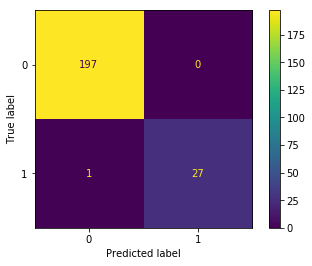

In [153]:
#Split Data 
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.33, random_state=42,stratify=y)





# Class Weight for Data Imbalancing
neg = len(y_train[y_train==0])
pos= len(y_train[y_train!=0])
total=len(y_train)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))





# Deep Learning 
model= tf.keras.Sequential([tf.keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[X_train.shape[1],X_train.shape[2]]),
           tf.keras.layers.SimpleRNN(10),tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=10,batch_size=100,validation_data=(X_test, y_test),class_weight=class_weight)
# evaluate the model
#saved_model = load_model('best_model.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()


print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

# Cross Validation

TRAIN: [  0   2   4   5   7   8   9  10  11  12  13  14  15  16  17  19  20  21
  22  24  25  26  27  28  29  30  31  32  33  34  36  37  38  39  40  41
  42  43  45  46  47  48  49  50  51  52  53  55  57  59  60  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  87  88  89  90  91  93  94  95  96  97  98  99 100 101 103 104
 105 106 107 109 110 111 112 113 114 115 117 118 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 138 139 140 141 142 143 144
 146 148 149 151 154 155 156 160 161 163 165 166 167 168 169 170 171 172
 173 175 177 179 180 181 182 183 185 186 187 188 189 190 191 193 194 195
 196 198 199 200 201 202 204 205 206 207 208 209 210 211 213 214 216 219
 220 221 222 223 225 226 227 231 232 233 234 236 237 238 239 240 241 242
 243 244 245 246 247 249 251 252 253 254 255 256 257 259 260 261 262 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 280 282 283 285 286
 287 288 289 290 291 293 294 295 297 298 299

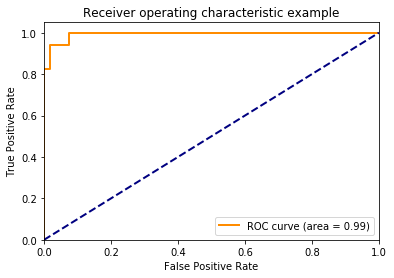

TRAIN: [  0   1   2   3   6   7   8   9  10  12  13  14  16  17  18  21  22  23
  26  27  28  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  48  49  50  52  53  54  55  56  58  59  61  62  63  64  66  68
  69  70  71  72  73  74  75  76  78  79  81  83  85  86  87  88  89  90
  91  92  93  94  97  99 100 102 103 104 106 107 108 113 114 115 116 117
 118 119 120 121 122 123 125 126 129 130 131 133 134 135 137 138 139 141
 142 143 144 145 147 148 149 150 152 153 154 155 156 157 158 159 160 162
 164 166 167 168 171 172 173 174 175 176 178 179 180 181 183 184 185 186
 187 188 189 190 191 192 194 195 196 197 198 200 201 202 203 204 205 206
 208 209 210 211 212 213 214 215 216 217 218 219 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 237 239 240 241 245 246 247 248 250 251
 252 253 254 255 256 257 258 260 261 263 264 265 267 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 284 285 287 289 290 291 292 295 296
 298 299 300 301 302 303 304 306 309 310 311

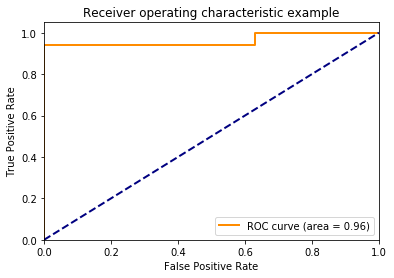

TRAIN: [  0   1   3   4   5   6   7   8   9  11  12  13  15  16  17  18  19  20
  22  23  24  25  26  28  29  30  31  32  33  34  35  36  38  40  41  42
  43  44  45  46  47  48  49  51  52  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  71  72  73  74  75  76  77  80  81  82  84
  85  86  87  88  89  92  94  95  96  98 100 101 102 103 105 106 107 108
 109 110 111 112 113 115 116 117 118 119 121 123 124 125 126 127 128 129
 130 131 132 134 135 136 137 138 139 140 141 142 143 145 146 147 148 150
 151 152 153 154 155 157 158 159 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 176 177 178 179 180 181 182 183 184 186 189 190 192 193
 194 195 196 197 198 199 200 201 202 203 205 207 208 209 212 215 217 218
 220 221 222 224 225 227 228 229 230 231 232 233 234 235 236 238 239 240
 241 242 243 244 246 248 249 250 251 252 253 254 255 258 259 260 261 262
 263 264 266 267 268 272 273 275 279 280 281 282 283 284 285 286 287 288
 289 290 292 293 294 295 296 297 298 299 305

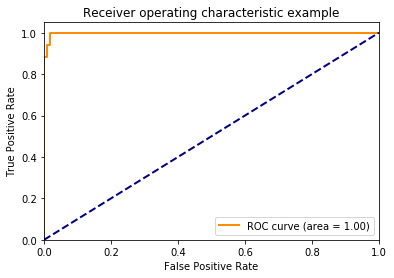

TRAIN: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  18  19  20
  21  22  23  24  25  27  28  29  31  35  36  37  39  40  44  47  50  51
  52  53  54  55  56  57  58  60  61  62  65  66  67  68  70  71  72  73
  75  77  78  79  80  81  82  83  84  85  86  89  90  91  92  93  94  95
  96  97  98  99 101 102 104 105 108 109 110 111 112 113 114 115 116 118
 119 120 122 124 127 128 132 133 134 136 137 139 140 141 142 143 144 145
 146 147 149 150 151 152 153 154 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 173 174 175 176 177 178 179 180 181 182 184 185 187
 188 190 191 192 193 195 197 198 199 202 203 204 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 228 229 230
 233 235 236 237 238 239 240 242 243 244 245 247 248 249 250 251 253 254
 255 256 257 258 259 262 263 264 265 266 268 269 270 271 272 273 274 276
 277 278 279 280 281 282 283 284 286 288 290 291 292 293 294 295 296 297
 299 300 301 302 303 304 305 306 307 308 309

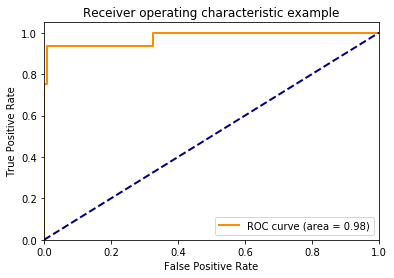

TRAIN: [  0   1   2   3   4   5   6  10  11  14  15  16  17  18  19  20  21  23
  24  25  26  27  30  31  32  33  34  35  37  38  39  41  42  43  44  45
  46  47  48  49  50  51  53  54  56  57  58  59  60  61  62  63  64  65
  67  69  70  74  76  77  78  79  80  82  83  84  86  87  88  90  91  92
  93  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 114 116 117 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 135 136 137 138 140 144 145 146 147 148 149 150 151 152 153 155 156
 157 158 159 160 161 162 163 164 165 169 170 171 172 174 175 176 177 178
 182 183 184 185 186 187 188 189 191 192 193 194 196 197 199 200 201 203
 204 205 206 207 210 211 212 213 214 215 216 217 218 219 220 221 223 224
 226 227 228 229 230 231 232 234 235 236 237 238 241 242 243 244 245 246
 247 248 249 250 252 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 274 275 276 277 278 279 281 283 284 285 286 287 288 289 291
 292 293 294 296 297 298 300 301 302 303 304

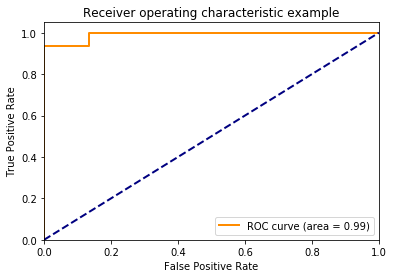

In [154]:
# fix random seed for reproducibility
seed = 7


# define 10-fold cross validation test harness
skf = StratifiedKFold(n_splits=5,random_state=7,shuffle=True)
k=1



for train_index, test_index in skf.split(padded,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = padded[train_index], padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    neg = len(y_train[y_train==0])
    pos= len(y_train[y_train!=0])
    total=len(y_train)
    
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))

    
    model= tf.keras.Sequential([tf.keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[padded.shape[1],padded.shape[2]]),
           tf.keras.layers.SimpleRNN(10),tf.keras.layers.Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    # Fit the model


    # simple early stopping
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    #mc = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


    history=model.fit(X_train, y_train, epochs=10,batch_size=100,validation_data=(X_test, y_test),class_weight=class_weight)
    # evaluate the model
    #saved_model = load_model('best_model.h5')

    scores = model.evaluate(X_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict_classes(X_test)
    cm=confusion_matrix(y_test, y_pred)
    
    y_score=model.predict(X_test)

    from sklearn.metrics import roc_curve, auc


    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


# Multi-Classification

In [142]:
data=pd.read_csv("erroronevent1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x,y=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x)):
    length.append(x[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post',maxlen=60)
print(padded.shape)

Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 18
(array([ 1,  2,  4,  6,  8, 10, 12, 14, 18]), array([190, 431,  69,  10,   2,   1,   2,   5,   2]))
(712, 60, 195)


In [143]:
data=pd.read_csv("erroronerror1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_error,y_error=preprocess(data,1)

#Max Length
length=[]
for i in range(len(x_error)):
    length.append(x_error[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_error = tf.keras.preprocessing.sequence.pad_sequences(x_error, padding='post',maxlen=60)
print(padded_error.shape)

y_error=2*y_error

Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 52
(array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 24, 34, 52]), array([250, 380,  31,   3,  17,   6,   8,   4,   1,   2,   2,   1,   1,
         1]))
(707, 60, 195)


In [144]:
data=pd.read_csv("missing_response1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_response,y_response=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_response)):
    length.append(x_response[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_response = tf.keras.preprocessing.sequence.pad_sequences(x_response, padding='post',maxlen=60)
print(padded.shape)

y_response=3*y_response

Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 25
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 18, 19, 25]), array([324, 306,  10,  49,   4,   6,   1,   1,   1,   1,   1,   2,   1,
         1,   1]))
(712, 60, 195)


In [160]:
data=pd.read_csv("missing_request3.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_request,y_request=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_request)):
    length.append(x_request[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_request = tf.keras.preprocessing.sequence.pad_sequences(x_request, padding='post',maxlen=60)
print(padded.shape)

y_request=4*y_request

Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 27
(array([ 1,  2,  3,  4,  5,  6,  7,  8, 14, 16, 17, 25, 27]), array([294, 274,  23,  66,   5,  10,   1,   1,   1,   1,   1,   1,   1]))
(679, 60, 195)


In [161]:
X_total=np.concatenate((padded,padded_error,padded_response,padded_request))
Y_total=np.concatenate((y,y_error,y_response,y_request))

print(X_total.shape)
print(Y_total.shape)

(2774, 60, 195)
(2774, 1)


In [162]:
encoder=LabelEncoder()
encoder.fit(Y_total)
encoded_y=encoder.transform(Y_total)
dummy_y=tf.keras.utils.to_categorical(encoded_y)

/home/alkhatib/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_total, dummy_y, test_size=0.2, random_state=42,stratify=dummy_y)

In [164]:
np.unique(dummy_y,axis=0,return_counts=True)

(array([[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32),
 array([  83,   92,   39,   83, 2477]))

In [165]:
np.unique(Y_total,axis=0,return_counts=True)

(array([[0.],
        [1.],
        [2.],
        [3.],
        [4.]]), array([2477,   83,   39,   92,   83]))

In [106]:
np.unique(y_train,axis=0,return_counts=True)[1][1]

43

In [112]:
np.unique(y_train,axis=0,return_counts=True)[0][2]

array([1., 0., 0.], dtype=float32)

Weight for class 0: 0.22
Weight for class 1: 6.72
Weight for class 2: 14.32
Weight for class 3: 6.00
Weight for class 4: 6.72
Train on 2219 samples, validate on 555 samples
Epoch 1/50
2219/2219 [==============================] - 6s 3ms/sample - loss: 1.4330 - acc: 0.5719 - val_loss: 1.1386 - val_acc: 0.7423
Epoch 2/50
2219/2219 [==============================] - 0s 224us/sample - loss: 1.2320 - acc: 0.8175 - val_loss: 0.8597 - val_acc: 0.8595
Epoch 3/50
2219/2219 [==============================] - 1s 240us/sample - loss: 0.9844 - acc: 0.9279 - val_loss: 0.5603 - val_acc: 0.9532
Epoch 4/50
2219/2219 [==============================] - 1s 241us/sample - loss: 0.8498 - acc: 0.9464 - val_loss: 0.4715 - val_acc: 0.9532
Epoch 5/50
2219/2219 [==============================] - 1s 243us/sample - loss: 0.7554 - acc: 0.9581 - val_loss: 0.4421 - val_acc: 0.9423
Epoch 6/50
2219/2219 [==============================] - 1s 234us/sample - loss: 0.6387 - acc: 0.9576 - val_loss: 0.3368 - val_acc: 0.9514
E

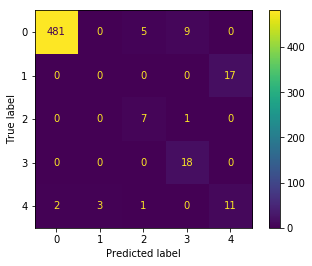

In [179]:
# Class Weight for Data Imbalancing
normal = np.unique(y_train,axis=0,return_counts=True)[1][4]
event  =  np.unique(y_train,axis=0,return_counts=True)[1][3]
error = np.unique(y_train,axis=0,return_counts=True)[1][2]
response  =  np.unique(y_train,axis=0,return_counts=True)[1][1]
request  =  np.unique(y_train,axis=0,return_counts=True)[1][0]

total=len(X_train)

weight_for_0 = (1 / normal) * (total / 5.0)
weight_for_1 = (1 / event) * (total / 5.0)
weight_for_2 = (1 / error) * (total / 5.0)
weight_for_3 = (1 / response) * (total / 5.0)
weight_for_4 = (1 / request) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2, 3:weight_for_3, 4:weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))



# Deep Learning 
model= tf.keras.Sequential([tf.keras.layers.SimpleRNN(50,return_sequences=True,input_shape=[X_train.shape[1],X_train.shape[2]]),
           tf.keras.layers.SimpleRNN(10),tf.keras.layers.Dense(5, activation='softmax')])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=50,batch_size=100,validation_data=(X_test, y_test),class_weight=class_weight,callbacks=[es])
# evaluate the model
#saved_model = load_model('best_model.h5')

l=[]
for i in y_test:
    l.append(np.argmax(i))
k=np.array(l)

# Multiclass
y_pred = model.predict_classes(X_test)
cm=confusion_matrix(k, y_pred)

print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

[1961    0    7   11    3    3    9    1    0   53    0    0   30    1
    0    0    0    1   73    0    1    6    0    0   59]


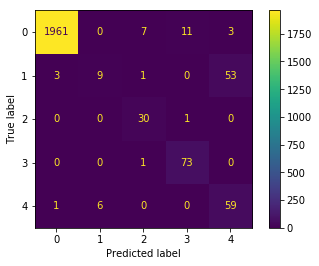

In [180]:
l=[]
for i in y_train:
    l.append(np.argmax(i))
k=np.array(l)

# Multiclass
y_pred = model.predict_classes(X_train)
cm=confusion_matrix(k, y_pred)

print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

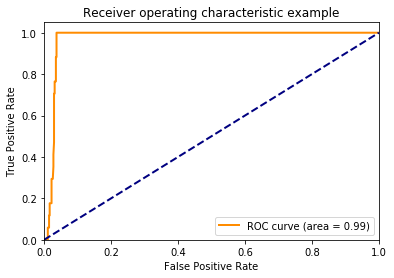

In [181]:
y_score=model.predict(X_test)

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[4], tpr[4], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

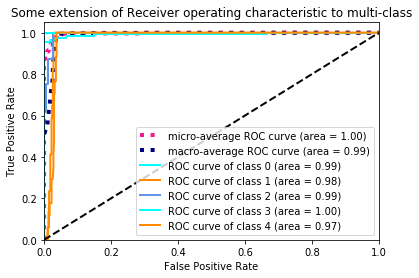

In [182]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [183]:
data=pd.read_csv("erroronevent2.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x,y=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x)):
    length.append(x[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post',maxlen=60)
print(padded.shape)

data=pd.read_csv("erroronerror2.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_error,y_error=preprocess(data,1)

#Max Length
length=[]
for i in range(len(x_error)):
    length.append(x_error[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_error = tf.keras.preprocessing.sequence.pad_sequences(x_error, padding='post',maxlen=60)
print(padded_error.shape)

y_error=2*y_error

data=pd.read_csv("missing_response2.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_response,y_response=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_response)):
    length.append(x_response[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_response = tf.keras.preprocessing.sequence.pad_sequences(x_response, padding='post',maxlen=60)
print(padded.shape)

y_response=3*y_response


data=pd.read_csv("missing_request4.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_request,y_request=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_request)):
    length.append(x_request[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_request = tf.keras.preprocessing.sequence.pad_sequences(x_request, padding='post',maxlen=60)
print(padded.shape)

y_request=4*y_request


Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 24
(array([ 1,  2,  4,  6,  8, 14, 18, 22, 24]), array([196, 426,  68,   8,   1,   3,   2,   1,   2]))
(707, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 30
(array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 22, 24, 30]), array([250, 296,  65,   5,  23,  11,   7,   3,   4,   4,   2,   2,   1]))
(673, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 20
(array([ 1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 15, 18, 20]), array([301, 281,  17,  62,   4,  11,   1,   3,   1,   1,   3,   1,   1]))
(707, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 22
(array([ 1,  2,  3,  4,  5,  6,  7,  9, 11, 13, 15, 21, 22]), array([315, 288, 

(2771, 60, 195)
(2771, 1)


/home/alkhatib/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2420    5   10   28    8   54    0    0    0    0    3    3   44    3
    1    4    1    7   68    1    9   14    5    5   78]


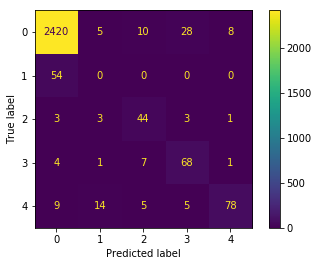

In [184]:
X_test=np.concatenate((padded,padded_error,padded_response,padded_request))
Y_testo=np.concatenate((y,y_error,y_response,y_request))

print(X_test.shape)
print(Y_testo.shape)

encoder=LabelEncoder()
encoder.fit(Y_testo)
encoded_y=encoder.transform(Y_testo)
Y_test=tf.keras.utils.to_categorical(encoded_y)

l=[]
for i in Y_test:
    l.append(np.argmax(i))
k=np.array(l)

# Multiclass
y_pred = model.predict_classes(X_test)
cm=confusion_matrix(k, y_pred)

print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

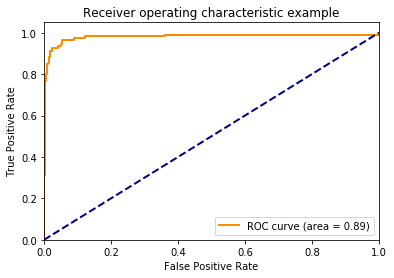

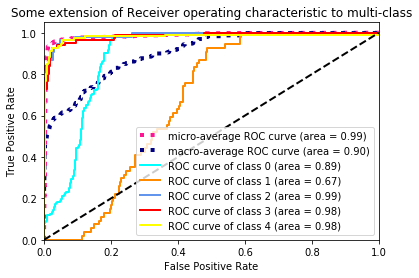

In [187]:
y_test=Y_test
y_score=model.predict(X_test)

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[4], tpr[4], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','yellow'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Binary Classification

In [188]:
data=pd.read_csv("erroronevent1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x,y=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x)):
    length.append(x[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post',maxlen=60)
print(padded.shape)

data=pd.read_csv("erroronerror1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_error,y_error=preprocess(data,1)

#Max Length
length=[]
for i in range(len(x_error)):
    length.append(x_error[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_error = tf.keras.preprocessing.sequence.pad_sequences(x_error, padding='post',maxlen=60)
print(padded_error.shape)

#y_error=2*y_error

data=pd.read_csv("missing_response1.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_response,y_response=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_response)):
    length.append(x_response[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_response = tf.keras.preprocessing.sequence.pad_sequences(x_response, padding='post',maxlen=60)
print(padded.shape)

#y_response=3*y_response


data=pd.read_csv("missing_request3.csv")
data=data.drop(columns="Unnamed: 0")

print("Number of columns before drop " + str(len(data.columns)))

data.drop(columns=[ 'length','Type', 'timesensitive','client_min',
       'client_max', 'client_resendMin', 'client_resendMax', 'errorRate',
       'server_min', 'server_max', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'],inplace=True)

print("Number of columns after drop " + str(len(data.columns)))

x_request,y_request=preprocess(data,0)

#Max Length
length=[]
for i in range(len(x_request)):
    length.append(x_request[i].shape[0])

print("Maximum sequence must be less than 60. In our case, it is " + str(max(length)))

print(np.unique(np.array(length),return_counts=True))

# Pad Sequences by 0 (Post padding)


padded_request = tf.keras.preprocessing.sequence.pad_sequences(x_request, padding='post',maxlen=60)
print(padded.shape)

#y_request=4*y_request


Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 18
(array([ 1,  2,  4,  6,  8, 10, 12, 14, 18]), array([190, 431,  69,  10,   2,   1,   2,   5,   2]))
(712, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 52
(array([ 1,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 24, 34, 52]), array([250, 380,  31,   3,  17,   6,   8,   4,   1,   2,   2,   1,   1,
         1]))
(707, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 25
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 18, 19, 25]), array([324, 306,  10,  49,   4,   6,   1,   1,   1,   1,   1,   2,   1,
         1,   1]))
(712, 60, 195)
Number of columns before drop 34
Number of columns after drop 16
Maximum sequence must be less than 60. In our case, it is 27
(array([ 1,  2,  3,  4,  5,  6,  7,  8

In [189]:
X_total=np.concatenate((padded,padded_error,padded_response,padded_request))
Y_total=np.concatenate((y,y_error,y_response,y_request))

Weight for class 0: 0.55
Weight for class 1: 5.11
Train on 1880 samples, validate on 927 samples
Epoch 1/10
1880/1880 [==============================] - 6s 3ms/sample - loss: 0.6626 - acc: 0.6532 - val_loss: 0.5312 - val_acc: 0.8425
Epoch 2/10
1880/1880 [==============================] - 0s 232us/sample - loss: 0.5945 - acc: 0.8766 - val_loss: 0.5471 - val_acc: 0.8393
Epoch 3/10
1880/1880 [==============================] - 0s 261us/sample - loss: 0.4869 - acc: 0.9117 - val_loss: 0.3547 - val_acc: 0.9407
Epoch 4/10
1880/1880 [==============================] - 0s 265us/sample - loss: 0.3523 - acc: 0.9335 - val_loss: 0.2835 - val_acc: 0.9126
Epoch 5/10
1880/1880 [==============================] - 1s 269us/sample - loss: 0.2604 - acc: 0.9410 - val_loss: 0.1805 - val_acc: 0.9525
Epoch 6/10
1880/1880 [==============================] - 0s 243us/sample - loss: 0.2030 - acc: 0.9559 - val_loss: 0.1645 - val_acc: 0.9450
Epoch 7/10
1880/1880 [==============================] - 0s 236us/sample - los

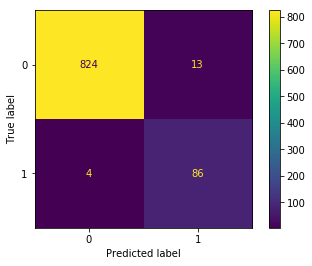

In [190]:
#Split Data 
X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.33, random_state=42,stratify=Y_total)


# Class Weight for Data Imbalancing
neg = len(y_train[y_train==0])
pos= len(y_train[y_train!=0])
total=len(y_train)

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))





# Deep Learning 
model= tf.keras.Sequential([tf.keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[X_train.shape[1],X_train.shape[2]]),
           tf.keras.layers.SimpleRNN(10),tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=10,batch_size=100,validation_data=(X_test, y_test),class_weight=class_weight)
# evaluate the model
#saved_model = load_model('best_model.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()


print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 

Train on 1880 samples, validate on 927 samples
Epoch 1/10
1880/1880 [==============================] - 8s 4ms/sample - loss: 0.6933 - acc: 0.8936 - val_loss: 0.6920 - val_acc: 0.9029
Epoch 2/10
1880/1880 [==============================] - 1s 529us/sample - loss: 0.6930 - acc: 0.9032 - val_loss: 0.6924 - val_acc: 0.9040
Epoch 3/10
1880/1880 [==============================] - 1s 541us/sample - loss: 0.6925 - acc: 0.9048 - val_loss: 0.6867 - val_acc: 0.9040
Epoch 4/10
1880/1880 [==============================] - 1s 530us/sample - loss: 0.6894 - acc: 0.3761 - val_loss: 0.7183 - val_acc: 0.0971
Epoch 5/10
1880/1880 [==============================] - 1s 547us/sample - loss: 0.6588 - acc: 0.6676 - val_loss: 0.6823 - val_acc: 0.8436
Epoch 6/10
1880/1880 [==============================] - 1s 533us/sample - loss: 0.6386 - acc: 0.8846 - val_loss: 0.6083 - val_acc: 0.8749
Epoch 7/10
1880/1880 [==============================] - 1s 542us/sample - loss: 0.6292 - acc: 0.8926 - val_loss: 0.6686 - val_a

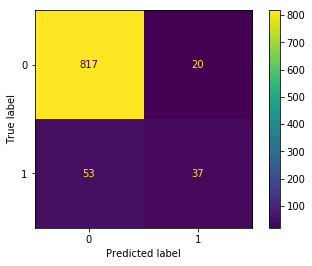

In [191]:
# Deep Learning 
model= tf.keras.Sequential([tf.keras.layers.LSTM(20,return_sequences=True,input_shape=[X_train.shape[1],X_train.shape[2]]),
           tf.keras.layers.LSTM(10),tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('LSTM.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=10,batch_size=100,validation_data=(X_test, y_test),class_weight=class_weight)
# evaluate the model
#saved_model = load_model('best_model.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()


print(cm.ravel())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)    
disp.plot() 